In [13]:
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import nibabel as nib
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

from nilearn.maskers import NiftiMasker
from nilearn.masking import compute_brain_mask
from nilearn.plotting import plot_stat_map, show
from nilearn.plotting import plot_roi, plot_glass_brain
from nilearn.image import clean_img

from function import *

# Loading the Data

In [15]:
# load beta images
# And clean them, replacing nans by 0s ...
beta_maps_dir = 'data/beta_maps'
beta_maps = []
for file in sorted(os.listdir(beta_maps_dir)):
    if file.endswith('.nii.gz'):
        map = nib.load(os.path.join(beta_maps_dir, file))
        beta_maps.append(clean_img(map, standardize=False, ensure_finite=True))

nb_sub = len(beta_maps)

print('Number of subjects: ', nb_sub)

Number of subjects:  49


# Masking the Data

Shape of the mask:  (91, 109, 91)


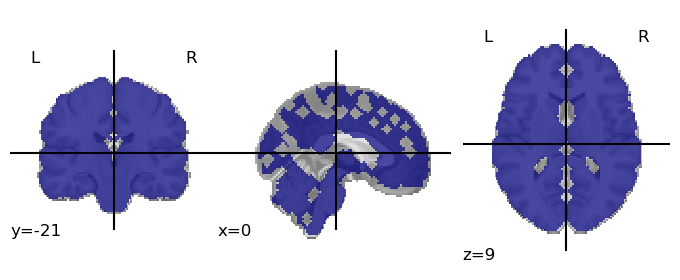

In [16]:
anat_path = 'data/anatomy/mask.nii'
anatomy = nib.load(anat_path)
mask = compute_brain_mask(anatomy)

print('Shape of the mask: ', mask.shape)
plot_roi(mask)

In [17]:
masker = NiftiMasker(mask_img=mask)

samples = []
for map in tqdm(beta_maps):
    samples.append(masker.fit_transform(map))
samples = np.concatenate(samples, axis=0)

100%|██████████| 49/49 [00:14<00:00,  3.28it/s]


# Labels

In [18]:
random.seed(42)
labels = np.tile(['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit'], 5*49)
print('Numbers of labels/training samples: ', len(labels))
# train_samples, test_samples, train_labels, test_labels = split(samples, labels, 4)

Numbers of labels/training samples:  1470


In [24]:
# Because it takes a while to run, we'll take one subject for testing and 5 for training.
num_subs_for_test = 4
num_imgs_per_sub = 30
beta_maps_test = nib.funcs.concat_images(beta_maps[:num_subs_for_test], axis = -1)
beta_maps_train = nib.funcs.concat_images(beta_maps[num_subs_for_test:], axis = -1)
labels_test = labels[:num_imgs_per_sub * num_subs_for_test]
labels_train = labels[num_imgs_per_sub * num_subs_for_test:]

In [25]:
beta_maps[0].shape

KeyboardInterrupt: 

In [26]:
from nilearn.decoding import SpaceNetClassifier
decoder = SpaceNetClassifier(penalty='tv-l1',
                             mask=mask,
                             max_iter=1000, # We need to change this to 1000 but even 10 takes a lot of time
                             cv=5,
                             n_jobs=10,
                             standardize=True,
                             memory="nilearn_cache",
                             memory_level=2,
                             verbose=1)

decoder.fit(beta_maps_train, labels_train)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(91, 109, 91, 1350),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


C:\Users\User\miniforge3\lib\site-packages\nilearn\maskers\nifti_masker.py:570: UserWarning: Persisting input arguments took 21.65s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 0), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 2.98s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


_____________________________________________________path_scores - 85.8s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 1), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.09s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 78.0s, 1.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 2), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.07s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 81.6s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 3), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.27s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 90.7s, 1.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 4), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.30s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 93.2s, 1.6min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 0), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.07s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 86.6s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 1), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.05s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 85.1s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 2), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.15s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 86.5s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 3), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.13s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 86.4s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 4), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.08s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 83.6s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 0), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.01s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 83.8s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 1), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.32s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 88.8s, 1.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 2), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.02s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 84.5s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 3), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.12s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 84.9s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 4), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.12s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 83.2s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 0), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.02s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 83.6s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 1), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.06s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 83.2s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 2), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.00s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 83.1s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 3), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.05s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 83.3s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 4), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 82.9s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 0), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.06s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 81.2s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 1), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.15s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 81.8s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 2), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.17s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 85.0s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 3), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.02s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 80.5s, 1.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 4), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.10s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 83.5s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 0), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.04s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 85.1s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 1), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.05s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 84.1s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 2), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 84.1s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 3), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.07s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


_____________________________________________________path_scores - 86.0s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x0000010786ABFD90>, loss='logistic'), array([[0.000000e+00, ..., 2.007889e-09],
       ...,
       [0.000000e+00, ..., 2.007889e-09]]), 
array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 4), debias=False, verbose=1, screening_percentile=21.077022986702598)


C:\Users\User\miniforge3\lib\site-packages\joblib\parallel.py:288: UserWarning: Persisting input arguments took 3.10s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 45.4min finished


_____________________________________________________path_scores - 86.2s, 1.4min
Time Elapsed: 2786.07 seconds, 46 minutes.


SpaceNetClassifier(cv=5,
                   mask=<nibabel.nifti1.Nifti1Image object at 0x00000107F5E6B280>,
                   max_iter=10, memory=Memory(location=nilearn_cache\joblib),
                   memory_level=2, penalty='tv-l1')

In [27]:
# Prediction
test_pred = decoder.predict(beta_maps_test)
# Return average accuracy
accuracy = (test_pred == labels_test).mean() * 100.
print("\nTV-l1  classification accuracy : %g%%" % accuracy)

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(91, 109, 91, 120),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals

TV-l1  classification accuracy : 71.6667%


C:\Users\User\miniforge3\lib\site-packages\nilearn\maskers\nifti_masker.py:570: UserWarning: Persisting input arguments took 1.76s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(


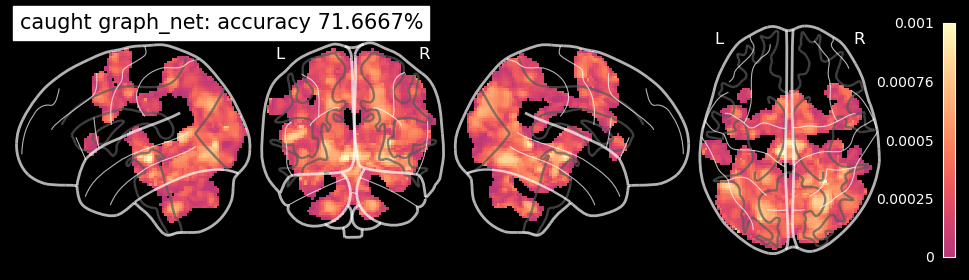

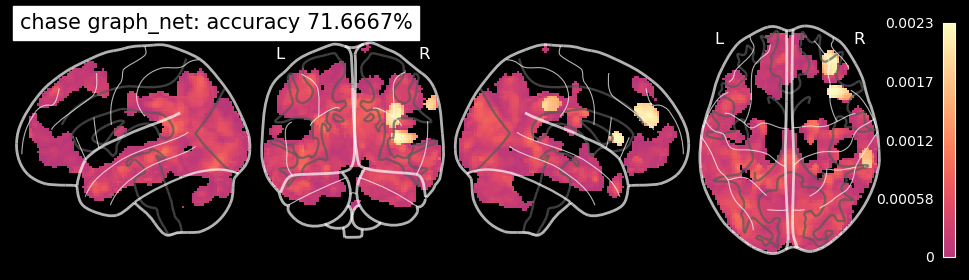

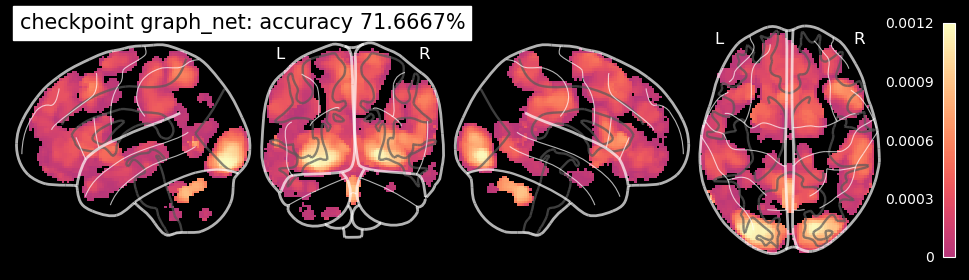

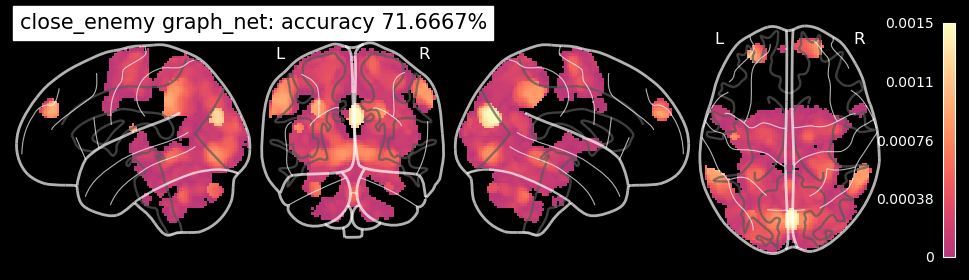

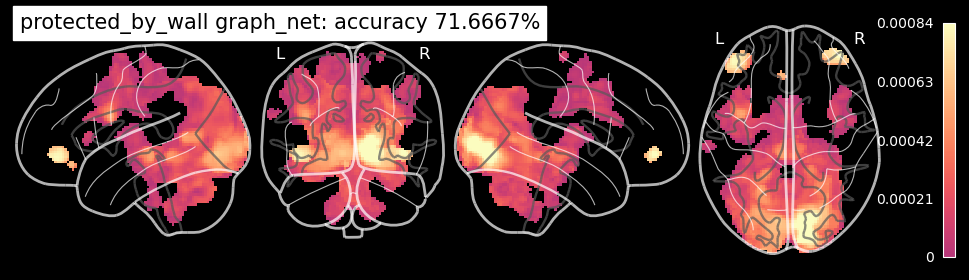

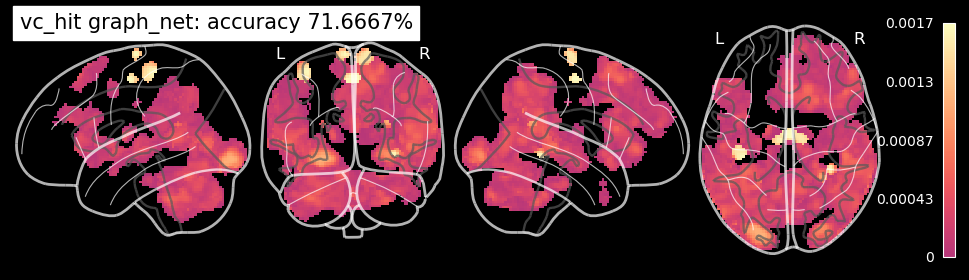

In [28]:
coef_img = decoder.coef_img_
# Plotting the searchlight results on the glass brain

conditions = ['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit']
for i, condition in enumerate(conditions):
    plot_glass_brain(coef_img.slicer[...,i], black_bg=True, colorbar=True, display_mode='lyrz', symmetric_cbar=False,
                 cmap='magma', title=condition + ' graph_net: accuracy %g%%' % accuracy)